# Depth Maps with OpenCV

## Binocular Depth Estimation

Using OpenCV and a binocular camera to create depth maps of objects:

> `disparity=x−x′=Bf/Z`

x and x′ are the distance between points in image plane corresponding to the scene point 3D and their camera center. B is the distance between two cameras (which we know) and f is the focal length of camera (already known). So in short, the above equation says that the depth of a point in a scene is inversely proportional to the difference in distance of corresponding image points and their camera centers. So with this information, we can derive the depth of all pixels in an image.

In [18]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import time

In [12]:
# data source
left_image = cv.imread('assets/horopter_left.png', cv.IMREAD_GRAYSCALE)
right_image = cv.imread('assets/horopter_right.png', cv.IMREAD_GRAYSCALE)

In [13]:
# larger block size = smoother/less accurate disparity map
stereo = cv.StereoBM_create(numDisparities=0, blockSize=21)
depth = stereo.compute(left_image, right_image)

There are some parameters when you get familiar with [StereoBM](https://docs.opencv.org/3.4/dd/d53/tutorial_py_depthmap.html), and you may need to fine tune the parameters to get better and smooth results. Parameters:

* __texture_threshold__: filters out areas that don't have enough texture for reliable matching
* __Speckle range and size__: Block-based matchers often produce "speckles" near the boundaries of objects, where the matching window catches the foreground on one side and the background on the other. In this scene it appears that the matcher is also finding small spurious matches in the projected texture on the table. To get rid of these artifacts we post-process the disparity image with a speckle filter controlled by the speckle_size and speckle_range parameters. speckle_size is the number of pixels below which a disparity blob is dismissed as "speckle." speckle_range controls how close in value disparities must be to be considered part of the same blob.
* __Number of disparities__: How many pixels to slide the window over. The larger it is, the larger the range of visible depths, but more computation is required.
* __min_disparity__: the offset from the x-position of the left pixel at which to begin searching.
* __uniqueness_ratio__: Another post-filtering step. If the best matching disparity is not sufficiently better than every other disparity in the search range, the pixel is filtered out. You can try tweaking this if texture_threshold and the speckle filtering are still letting through spurious matches.
* __prefilter_size and prefilter_cap__: The pre-filtering phase, which normalizes image brightness and enhances texture in preparation for block matching. Normally you should not need to adjust these.

In [10]:
print(depth)

[[-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 ...
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]]


(-0.5, 649.5, 508.5, -0.5)

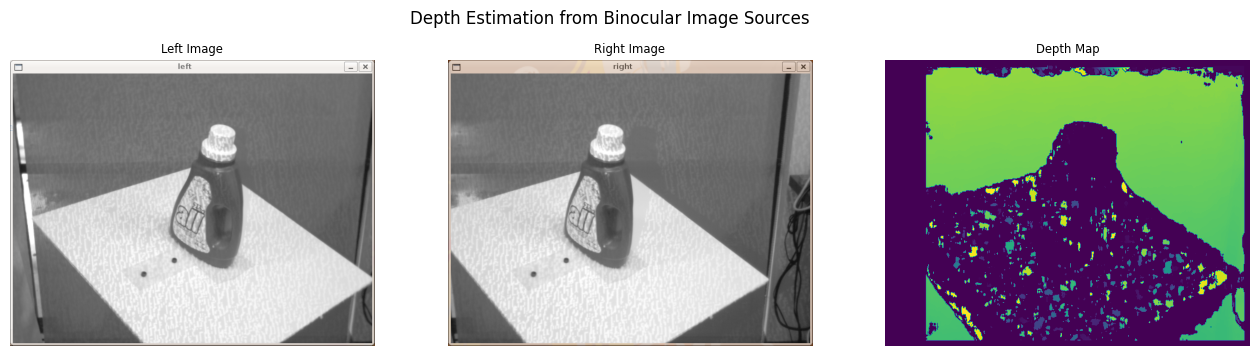

In [17]:
plt.figure(figsize=(16, 4))
plt.suptitle('Depth Estimation from Binocular Image Sources')

ax = plt.subplot(1, 3, 1)
img_title = 'Left Image'
image = plt.imread('assets/left.png')
plt.imshow(image, cmap=plt.cm.binary)
plt.title(img_title, fontsize='small')
plt.axis(False)

ax = plt.subplot(1, 3, 2)
img_title = 'Right Image'
image = plt.imread('assets/right.png')
plt.imshow(image, cmap=plt.cm.binary)
plt.title(img_title, fontsize='small')
plt.axis(False)

ax = plt.subplot(1, 3, 3)
img_title = 'Depth Map'
plt.imshow(depth)
plt.title(img_title, fontsize='small')
plt.axis(False)

[Image Source: wiki.ros.org](https://wiki.ros.org/stereo_image_proc/Tutorials/ChoosingGoodStereoParameters)

## Binocular Depth Estimation

### MiDaSv2.1

* [Model Releases](https://github.com/isl-org/MiDaS/releases)

667 1000


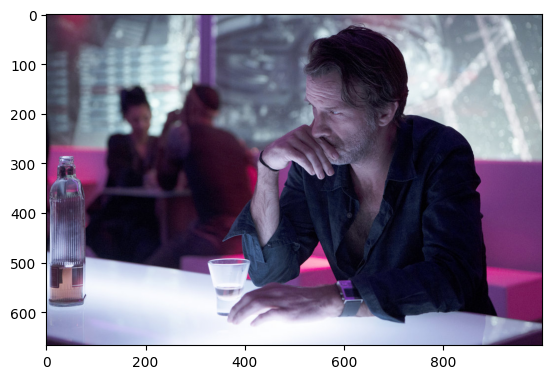

In [31]:
img_bgr = cv.imread('assets/bar.jpg')
img = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)
imgHeight, imgWidth, channels = img.shape

plt.imshow(img)

print(imgHeight, imgWidth)

In [ ]:
#!wget https://github.com/isl-org/MiDaS/releases/download/v2_1/model-f6b98070.pb -P models
!wget https://github.com/isl-org/MiDaS/releases/download/v2_1/model-small.onnx -P models

In [23]:
path_model = "models/"

# pick MiDaS model
# model_name = "model-f6b98070.onnx"; # MiDaS v2.1 Large
model_name = "model-small.onnx"; # MiDaS v2.1 Small

# load the model
model = cv.dnn.readNet(path_model + model_name)

if (model.empty()):
    print("Could not load the neural net! - Check path")

In [25]:
# Set backend and target to CUDA to use GPU
model.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
model.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA)

In [28]:
# Create Blob from Input Image

# MiDaS v2.1 Large ( Scale : 1 / 255, Size : 384 x 384, Mean Subtraction : ( 123.675, 116.28, 103.53 ), Channels Order : RGB )
# blob = cv.dnn.blobFromImage(img, 1/255., (384,384), (123.675, 116.28, 103.53), True, False)

# MiDaS v2.1 Small ( Scale : 1 / 255, Size : 256 x 256, Mean Subtraction : ( 123.675, 116.28, 103.53 ), Channels Order : RGB )
blob = cv.dnn.blobFromImage(img, 1/255., (256,256), (123.675, 116.28, 103.53), True, False)

In [36]:
# Set input to the model
model.setInput(blob)

# Make forward pass in model
output = model.forward()

output = output[0,:,:]
output = cv.resize(output, (imgWidth, imgHeight))

# Normalize the output
output = cv.normalize(output, None, 0, 1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

img = cv.cvtColor(img, cv.COLOR_RGB2BGR)

(-0.5, 999.5, 666.5, -0.5)

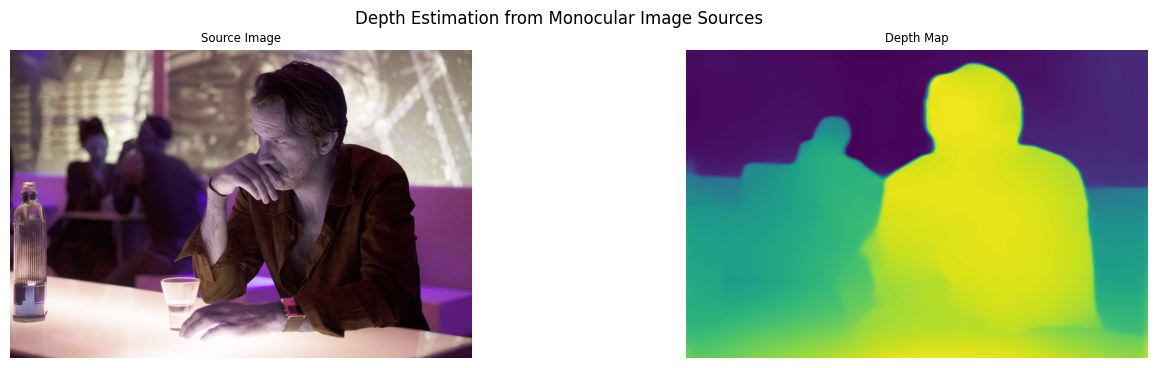

In [37]:
plt.figure(figsize=(16, 4))
plt.suptitle('Depth Estimation from Monocular Image Sources')

ax = plt.subplot(1, 2, 1)
img_title = 'Source Image'
plt.imshow(img)
plt.title(img_title, fontsize='small')
plt.axis(False)

ax = plt.subplot(1, 2, 2)
img_title = 'Depth Map'
plt.imshow(output)
plt.title(img_title, fontsize='small')
plt.axis(False)